# Parameterizing Radial Gas Flows in One-Zone Models

In the multi-ring models for the Milky Way, each annulus is described by a one-zone model, but coupled to the others in that they are allowed to exchange gas and stars. When radial flows are present, there will be an additional pair of source and sink terms for the advection of material into the present annulus from the next ring out as well as the advection of material from the present annulus into the next one in. The generalized expression for the enrichment rate of some alpha element is given by

$$
\dot{M}_\alpha = y_\alpha \dot{M}_\star - Z_\alpha \dot{M}_\star \left(1 + \eta - r\right)
+ \dot{M}_{\alpha,\text{flow,in}} - \dot{M}_{\alpha,\text{flow,out}}.
$$

where $\dot{M}_\star$ is the star formation rate (SFR), $y_\alpha$ is the massive star yield, $Z_\alpha$ is the instantaneous abundance by mass, $\eta$ is the mass loading factor, $r \approx 0.4$ is the instantaneous recycling correction, and $\dot{M}_{\alpha,\text{flow,in}}$ and $\dot{M}_{\alpha,\text{flow,out}}$ are the terms accounting for the inward advection of metals.

Here I will assume that the flow is idealized in that the distribution of radial velocities in the ISM is a delta function at some bulk inward flow velocity $v_R$. For a ring whose inner radius is $R$, the mass of gas that will flow into the next inner ring can be expressed as the area fraction of the ring times the gas mass $M_g$ itself:

$$
\begin{align}
f(R) &= \frac{
    \pi \left[\left(R + v_R \Delta t\right)^2 - R^2\right]
}{
    \pi \left[\left(R + \Delta R\right)^2 - R^2\right]
}
\\
&= \frac{
    2 R v_R \Delta t + v_R^2 \Delta t^2
}{
    2 R \Delta R + \Delta R^2
}
\\
\implies M_{g,\text{flow,out}} &= \frac{
    2 R v_R \Delta t + v_R^2 \Delta t^2
}{
    2 R \Delta R + \Delta R^2
} M_g.
\end{align}
$$

The *rate* of flow out of the zone can then be approximated by dividing by the timestep size:

$$
\dot{M}_{g,\text{flow,out}} \approx \frac{
    2 R v_R + v_R^2 \Delta t
}{
    2 R \Delta R + \Delta R^2
} M_g(R + \Delta R).
$$

The rate of inward flow from the next annulus out then follows trivially as it is the same expression, but evaluated at $R + \Delta R$:

$$
\dot{M}_{g,\text{flow,in}} = \frac{f(R + \Delta R)}{\Delta t} M_g(R) \approx \frac{
    2 \left(R + \Delta R\right) v_R + v_R^2 \Delta t
}{
    2 \left(R + \Delta R\right) \Delta R + \Delta R^2
} M_g(R).
$$

This radial advection of gas carries the metals in the ISM with it. Specifically, the mass *gained* in a given annulus is at the metallicity of the next ring while the mass *lost* is at the metallicity of the current ring:

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= \dot{M}_{\alpha,\text{flow,in}} - \dot{M}_{\alpha,\text{flow,out}}
\\
&= Z_\alpha(R + \Delta R)\dot{M}_{g,\text{flow,in}} - Z_\alpha(R)\dot{M}_{g,\text{flow,out}}
\\
&= Z_\alpha(R + \Delta R) M_g(R + \Delta R) \frac{f(R + \Delta R)}{\Delta t} +
Z_\alpha(R) M_g(R) \frac{f(R)}{\Delta t}.
\end{align}
$$

I apply this approximation to cases in which the rings are *narrow*, meaning that the width of each ring is small compared to the scale radius of the galactic disk, the galactic abundance gradient, etc. Furthermore, the timestep size must be small to ensure that the model Galaxy is well-resolved. It is therefore reasonable to approximate $Z_\alpha$, $M_g$, and $f$ at $R + \Delta R$ as perturbations of the ir values in the current ring at radius $R$:

$$
\begin{align}
Z_\alpha(R + \Delta R) &\approx Z_\alpha(R) + \frac{\partial Z_\alpha}{\partial R} \Delta R
\\
M_g(R + \Delta R) &\approx M_g(R) + \frac{\partial M_g}{\partial R} \Delta R.
\\
f(R + \Delta R) &\approx f(R) + \frac{\partial f}{\partial R} \Delta R
\end{align}
$$

For choices about the Galactic abundance and surface density gradients, I can then obtain an expression for $\dot{M}_{\alpha,\text{flow}}$ as a function of radius $R$, the bulk flow velocity $v_R$, and the ring width $\Delta R$.

## The radial abundance gradient

Abundance gradients are typically parameterized as a linear decline in the logarithmic abundance [X/H] for some element X. This corresponds to an exponential decline in the mass fraction $Z_X$. Applying this to an alpha element for a given gradient slope $A$:

$$
\begin{align}
\text{[$\alpha$/H]} &= A\left(R - R_\odot\right)
\\
\implies Z_\alpha &= Z_{\alpha,\odot} 10^{A(R - R_\odot)}
\\
&= Z_{\alpha,\odot} e^{-(R - R_\odot) / R_\alpha},
\end{align}
$$

where $R_\alpha = -(A \ln 10)$ is the e-folding scale radius of abundance gradient ($A < 0$ for a declining abundance gradient) and $R_\odot = 8$ kpc is an assumed Galactocentric distance of the Sun.

$$
\begin{align}
\frac{\partial Z_\alpha}{\partial R} &= Z_{\alpha,\odot}
\left(\frac{-1}{R_\alpha}\right)e^{-(R - R_\odot) / R_\alpha}
\\
&= \frac{-1}{R_\alpha} Z_\alpha(R)
\\
\implies Z_\alpha(R + \Delta R) &\approx Z_\alpha(R) \left(1 - \frac{\Delta R}{R_\alpha}\right).
\end{align}
$$

## The radial surface density gradient

The surface density of gas in the Galactic disk is typically parameterized as exponential:

$$
\Sigma_g(R) = \Sigma_{g,0} e^{-R / R_g},
$$

where $R_g$, similar to $R_\alpha$, is the e-folding scale radius of the gas disk. For thin rings, the mass can be approximated as $M_g \approx \Sigma_g(R) 2\pi R \Delta R$. In computing how the mass in the rings change with radius, there will therefore be terms which account for the area of the ring changing with radius in addition to the changes in surface density.

$$
\begin{align}
\frac{\partial M_g}{\partial R} &= 2\pi \Delta R \Sigma_g(R) +
2\pi R \Delta R \frac{\partial \Sigma_g(R)}{\partial R}
\\
&= 2\pi \Delta R \Sigma_g(R) + 2\pi R \Delta R \Sigma_{g,0}
\left(\frac{-1}{R_g}\right)e^{-R / R_g}
\\
&= 2\pi \Delta R \Sigma_g(R) - 2\pi \left(\frac{R}{R_g}\right) \Delta R \Sigma_{g}(R)
\\
&= 2\pi R\Delta R \Sigma_g(R) \left[\frac{1}{R} - \frac{1}{R_g}\right]
\\
&= M_g(R) \left[\frac{1}{R} - \frac{1}{R_g}\right]
\\
\implies M_g(R + \Delta R) &\approx M_g(R) \left[1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right].
\end{align}
$$

In the above expression, the $+\Delta R / R$ term accounts for the increasing area of the ring while the $-\Delta R / R_g$ term accounts for the decrease in surface density with increasing $R$.

## The flow fraction

As the inner radius of the ring $R$ changes, so too does the area fraction $f$ of gas that will leave the annulus in a given $\Delta t$ timestep.

$$
\begin{align}
\frac{\partial f}{\partial R} &= \frac{\partial}{\partial R}
\left[\frac{
    2R v_R \Delta t + v_R^2 \Delta t^2
}{
    2R \Delta R + \Delta R^2
}
\right]
\\
&= \frac{
    \left(2R \Delta R + \Delta R^2\right) 2v_R \Delta t -
    \left(2R v_R \Delta t + v_R^2 \Delta t^2\right) 2\Delta R
}{
    \left(2R \Delta R + \Delta R^2\right)^2
}
\\
&= \frac{
    4 R v_R \Delta R \Delta t + 2 v_R \Delta R^2 \Delta t -
    4 R v_R \Delta R \Delta t + 2 v_R^2 \Delta R \Delta t^2
}{
    \left(2R \Delta R + \Delta R^2\right)^2
}
\\
&= \frac{
    2 v_R \Delta R \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)^2
}
\\
&= f(R) \frac{
    2 v_R \Delta R \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)^2
} \left(\frac{
    2 R \Delta R + \Delta R^2
}{
    2 R v_R \Delta t + v_R^2 \Delta t^2
}\right)
\\
&= f(R) \frac{
    2 v_R \Delta R \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)\left(2 R v_R \Delta t + v_R^2 \Delta t^2\right)
}
\\
\implies f(R + \Delta R) &\approx f(R) \left[1 + \frac{
    2 v_R \Delta R^2 \Delta t \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R\Delta R + \Delta R^2\right)\left(2 R v_R \Delta t + v_R^2 \Delta t^2\right)
}\right]
\\
&= f(R) \left[1 + \frac{
    2 v_R \Delta R \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R + \Delta R\right)\left(2 R v_R + v_R^2 \Delta t\right)
}\right]
\end{align}
$$

## The metal flow rate

Tying each of these terms together results in the following expression for the total flow rate:

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= Z_\alpha(R + \Delta R) M_g(R + \Delta R) \frac{f(R + \Delta R)}{\Delta t} -
Z_\alpha(R) M_g(R) \frac{f(R)}{\Delta t}
\\
&= Z_\alpha(R) M_g(R) \frac{f(R)}{\Delta t} \left[1 -
\left(1 - \frac{\Delta R}{R_\alpha}\right)
\left(1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right)
\left(1 + \frac{
    2 v_R \Delta R \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R + \Delta R\right)\left(2 R v_R + v_R^2 \Delta t\right)
}\right)
\right]
\\
&= Z_\alpha(R) M_g(R) \frac{
    2 R v_R + v_R^2 \Delta t
}{
    2 R \Delta R + \Delta R^2
}\left[1 -
\left(1 - \frac{\Delta R}{R_\alpha}\right)
\left(1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right)
\left(1 + \frac{
    2 v_R \Delta R \left(\Delta R - v_R \Delta t\right)
}{
    \left(2R + \Delta R\right)\left(2 R v_R + v_R^2 \Delta t\right)
}\right)
\right].
\end{align}
$$

Now that I've obtained an expression for $\dot{M}_{\alpha,\text{flow}}$ given choices of $\Delta R$ and $\Delta t$, I take the limits as $\Delta R \rightarrow 0$ and $\Delta t \rightarrow 0$. For the timestep size, this is trivial as the few terms dependent on $\Delta t$ simply disappear:

$$
\lim_{\Delta t \rightarrow 0} \dot{M}_{\alpha,\text{flow}} = Z_\alpha(R) M_g(R) \frac{
    2 R v_R
}{
    2 R \Delta R + \Delta R^2
}\left[1 -
\left(1 - \frac{\Delta R}{R_\alpha}\right)
\left(1 + \frac{\Delta R}{R} - \frac{\Delta R}{R_g}\right)
\left(1 + \frac{
    2 v_R \Delta R^2
}{
    4 R^2 v_R + 2 R v_R \Delta R
}\right)
\right].
$$

Taking the limit as $\Delta R \rightarrow 0$ is significantly less trivial as both the quantity in square brackets and $2R\Delta R + \Delta R^2$ go to zero, resulting in the $0/0$ indeterminate form. I therefore apply L'Hopital's rule, taking the partial derivative with respect to $\Delta R$ of both quantities and then taking their limits as $\Delta R \rightarrow 0$. This results in the following expression for $\dot{M}_{\alpha,\text{flow}}$

$$
\begin{align}
\dot{M}_{\alpha,\text{flow}} &= Z_\alpha(R) M_g(R) \frac{2Rv_R}{2R}
\left(\frac{1}{R_\alpha} + \frac{1}{R_g} - \frac{1}{R}\right)
\\
&= Z_\alpha \dot{M}_\star \tau_\star v_R
\left(\frac{1}{R_\alpha} + \frac{1}{R_g} - \frac{1}{R}\right),
\end{align}
$$

where I have substituted in for the star formation rate (SFR) $\dot{M}_\star$ and the star formation efficiency (SFE) timescale $\tau_\star \equiv M_g / \dot{M}_\star$ and dropped the notation of quantities as a function of radius $R$ for simplicity.

This expression makes intuitive sense. As the local abundance by mass increases, so too does the flow rate in proportion. The same goes for the local star formation rate and SFE timescale, as they are tied to the local gas supply, and the more gas there is, the more that will be transferred between rings if the flow is uniform. The linear proportion with $v_R$ is expected. As $R_\alpha$ increases, the metallicity gradient flattens, so the flow rate is smaller due to a more similar composition between rings. With increasing $R_g$, the gas surface density profile flattens (i.e., the disk becomes more extended), and the flow rate decreases in this case as well because the mass gained is more closely balanced by the mass lost to flows. 

The physical reason for the appearance of the $1 / R$ term is less intuitive. It arises in taking the derivative of the gas supply with respect to radius $\partial M_g / \partial R$, specifically from the change in area of an annulus with radius (remember that it's the *surface density* of gas which exponentially declines with $R$ as opposed to $M_g$ itself). A way to think about this term is that radial flows matter less at small $R$ due to the fact that the area of an annulus is small, so even though the surface density is highest in the center of the galaxy, the annuli with the highest gas masses in the [Johnson et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.4484J/abstract) Milky Way models is in the annulus at approximately $R_g$.

## Impact on Enrichment Rates & Equilibrium Abundances

Assessing the impact of radial flows on enrichment rates and equilibrium abundances first requires extending the above calculations to the total gas supply. The calculation proceeds the same, but without $Z_\alpha(R)$. As a result, there is no $(1 - \Delta R / R_\alpha)$ term which arises, and consequently no $1 / R_\alpha$ term in the final expression. It therefore compactifies notation to introduce the following dimensionless parameters:

$$
\begin{align}
\gamma_\text{flow} &\equiv \tau_\star v_R \left(\frac{1}{R_g} - \frac{1}{R}\right)
\\
\mu_\text{flow} &\equiv \tau_\star v_R \left(\frac{1}{R_\alpha} + \frac{1}{R_g} - \frac{1}{R}\right),
\end{align}
$$

allowing the rate of change of the alpha element mass due solely to radial flows to be expressed as

$$
\dot{M}_{\alpha,\text{flow}} = Z_\alpha \dot{M}_\star \mu_\text{flow}.
$$

If $\mu_\text{flow} > 0$, then the radial flow is such that the metal gain from the outer bordering ring at $R + \Delta R$ is stronger than the metal loss to the inner bordering ring at $R - \Delta R$, making flows a net source term. Conversely, if $\mu_\text{flow} < 0$, then radial flows are a net sink term. Note that $v_R$ was previously defined to be positive for an inward flow, so $v_R > 0$ if the gas is moving inward and $v_R < 0$ if the gas is moving outward. Defining $v_R < 0$ for an inward flow would simply flip the sign on $\mu_\text{flow}$ and $\gamma_\text{flow}$.

The total enrichment rate of an alpha element can then be expressed as

$$
\begin{align}
\dot{M}_\alpha &= y_\alpha \dot{M}_\star - Z_\alpha \dot{M}_\star \left(1 + \eta - r\right) +
Z_\alpha \dot{M}_\star \mu_\text{flow}
\\
&= y_\alpha \dot{M}_\star - Z_\alpha \dot{M}_\star \left(1 + \eta - r - \mu_\text{flow}\right).
\end{align}
$$

Similarly, the change in the total gas supply becomes

$$
\begin{align}
\dot{M}_g &= \dot{M}_\text{in} - \dot{M}_\star \left(1 + \eta - r\right) + \dot{M}_\star \gamma_\text{flow}
\\
&= \dot{M}_\text{in} - \dot{M}_\star \left(1 + \eta - r - \gamma_\text{flow}\right).
\end{align}
$$

In fact, the same equilibrium expressions in [Weinberg, Andrews & Freudenburg (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...837..183W/abstract) now apply under the simple transformation that $1 + \eta - r \rightarrow 1 + \eta - r - \beta_\text{flow}$. The depletion time $\tau_\text{dep}$ is given by

$$
\tau_\text{dep} \equiv \frac{\tau_\star}{1 + \eta - r - \beta_\text{flow}},
$$

and the alpha element equilibrium abundance for an exponential SFH becomes

$$
Z_{\alpha,\text{eq}} = \frac{y_\alpha}{1 + \eta - r - \beta_\text{flow} - \tau_\star / \tau_\text{sfh}}.
$$

In [1]:
from plots.mpltoolkit import mpl_loc, named_colors, fancy_legend, load_mpl_presets
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
load_mpl_presets()

_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

/var/home/johnson.7419.local/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
def ralpha(A):
    r"""
    The e-folding scale radius of the metallicity gradient by mass.
    
    See :math:`R_\alpha` in notes above.
    """
    return -1 / (A * np.log(10))

def mu_flow(taustar, vr, A, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_ # vr now in kpc / Gyr
    return taustar * vr * (1 / ralpha(A) + 1 / rg - 1 / R)

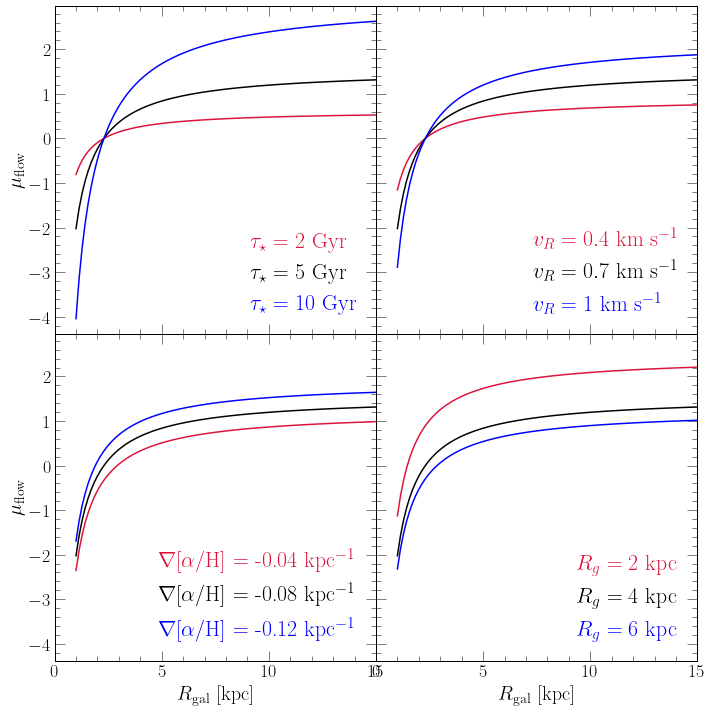

In [3]:
fig = plt.figure(figsize = (10, 10))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i == 0 or i == 2:
        axes[i].set_ylabel(r"$\mu_\text{flow}$")
    else:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    if i >= 2:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]")
    else:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    axes[i].set_xlim([0, 15])

colors = ["crimson", "black", "blue"]
taustar = [2, 5, 10]
vr = [0.4, 0.7, 1.0]
A = [-0.04, -0.08, -0.12]
rg = [2, 4, 6]

xvals = np.linspace(1, 15, 100)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\tau_\star = %g$ Gyr" % (taustar[i])
    }
    yvals = [mu_flow(taustar[i], vr[1], A[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$v_R = %g$ km s$^{-1}$" % (vr[i])
    }
    yvals = [mu_flow(taustar[1], vr[i], A[1], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\nabla$[$\alpha$/H] = %g kpc$^{-1}$" % (A[i])
    }
    yvals = [mu_flow(taustar[1], vr[1], A[i], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$R_g = %g$ kpc" % (rg[i])
    }
    yvals = [mu_flow(taustar[1], vr[1], A[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)

for i in range(4):
    kwargs = {
        "loc": mpl_loc("lower right"),
        "handlelength": 0,
        "fontsize": 22
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.show()